In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from random import randint
from IPython.display import HTML, display

In [2]:
def parseControllerLogs(path):
    # Read the controller log
    left = []
    right = []
    with open(path+'_controller.log') as file:
        for line in file:
            if (line.startswith('Power:')):
                power = line[6:].split(',')
                left.append(int(power[0].strip()))
                right.append(int(power[1].strip()))
    # Read the observer log
    distance = []
    percent_in_zone = 0
    with open(path+'_observer.log') as file:
        for line in file:
            if (line.startswith('Current distance:')):
                distance.append(float(line[17:].strip()))
            if (line.startswith('percent of time in zone:')):
                percent_in_zone = float(line[24:].strip()[:-1].replace(',','.'))
    # Observer prints distance at 4 Hz, the controller at ~20 Hz
    time = np.arange(0, len(distance)/4, 1/20)
    distance = sig.resample(distance, len(time))
    left = sig.resample(left, len(time))
    right = sig.resample(right, len(time))
    # Return all the data
    data = np.vstack((left, right, distance))
    return time, data, percent_in_zone

In [3]:
# Load multiple sets
def appendReturn(arr):
    app = []
    arr.append(app)
    return app

def loadMultiple(path, Nscenarios, Nruns):
    time = None
    go_data = []
    java_data = []
    go_zone = []
    java_zone = []

    for i in range(1,Nscenarios+1):
        go_sce = appendReturn(go_data)
        java_sce = appendReturn(java_data)
        go_zone_sce = appendReturn(go_zone)
        java_zone_sce = appendReturn(java_zone)

        for j in range(1,Nruns+1):
            runpath = path+'Scenario'+str(i)+'/Run'+str(j)+'/'
            time, go_run, go_run_zone = parseControllerLogs(runpath+'go')
            go_sce.append(go_run)
            go_zone_sce.append(go_run_zone)
            time, java_run, java_run_zone = parseControllerLogs(runpath+'java')
            java_sce.append(java_run)
            java_zone_sce.append(java_run_zone)
    
    return time, go_data, java_data, go_zone, java_zone

In [4]:
time, go_data, java_data, go_zone, java_zone = loadMultiple('experiments/experiment1/', 5, 5)

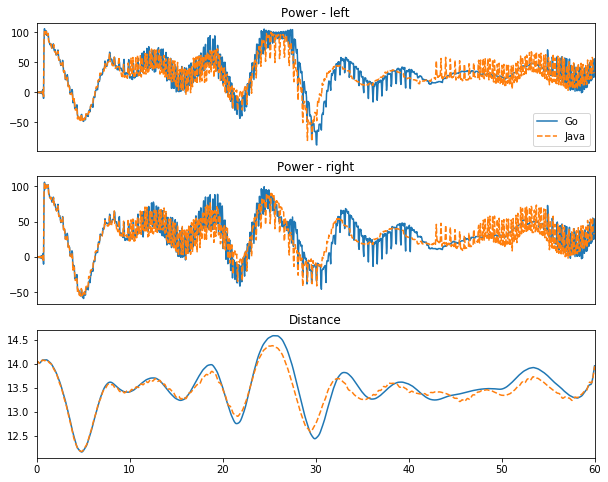

In [5]:
# Pick a scenario at random
rnd_scenario = randint(0,4)
rnd_java = randint(0,4)
rnd_go = randint(0,4)

# Make comparison figure
plt.figure(1, figsize=(10,8))

ax1 = plt.subplot(3,1,1)
plt.plot(time, go_data[rnd_scenario][rnd_go][0,:])
plt.plot(time, java_data[rnd_scenario][rnd_java][0,:], '--')

ax2 = plt.subplot(3,1,2)
plt.plot(time, go_data[rnd_scenario][rnd_go][1,:])
plt.plot(time, java_data[rnd_scenario][rnd_java][1,:], '--')

ax3 = plt.subplot(3,1,3)
plt.plot(time, go_data[rnd_scenario][rnd_go][2,:])
plt.plot(time, java_data[rnd_scenario][rnd_java][2,:], '--')

ax1.set_xticks([])
ax2.set_xticks([])
time_lim = (time[0],time[-1])
ax1.set_xlim(time_lim)
ax2.set_xlim(time_lim)
ax3.set_xlim(time_lim)

ax1.set_title('Power - left')
ax2.set_title('Power - right')
ax3.set_title('Distance')

ax1.legend(('Go','Java'), loc='lower right')

plt.savefig('comparison_graph.eps')

plt.show()

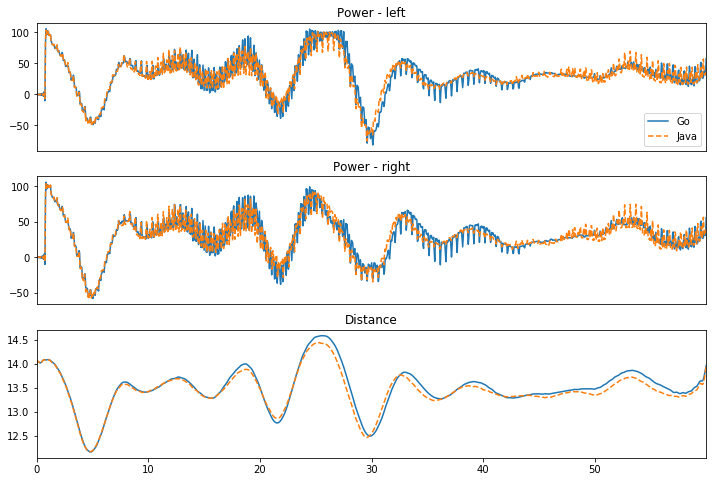

In [6]:
# Averaged values
go_avg = np.mean(np.stack(go_data[rnd_scenario], axis=2), axis=2)
java_avg = np.mean(np.stack(java_data[rnd_scenario], axis=2), axis=2)

# Make comparison figure
plt.figure(2, figsize=(12,8))

ax1 = plt.subplot(3,1,1)
plt.plot(time, go_avg[0,:])
plt.plot(time, java_avg[0,:], '--')

ax2 = plt.subplot(3,1,2)
plt.plot(time, go_avg[1,:])
plt.plot(time, java_avg[1,:], '--')

ax3 = plt.subplot(3,1,3)
plt.plot(time, go_avg[2,:])
plt.plot(time, java_avg[2,:], '--')

ax1.set_xticks([])
ax2.set_xticks([])
time_lim = (time[0],time[-1])
ax1.set_xlim(time_lim)
ax2.set_xlim(time_lim)
ax3.set_xlim(time_lim)

ax1.set_title('Power - left')
ax2.set_title('Power - right')
ax3.set_title('Distance')

ax1.legend(('Go','Java'), loc='lower right')

plt.show()

In [7]:
# Make stats table
num_sce = len(go_zone)
num_runs = len(go_zone[0])

html = '<table>'
html += '<tr>'
html += '<th>Language:</th>'
for i in range(0,num_runs):
    html += '<th>Run '+str(i+1)+':</th>'
html += '</tr>'

for i in range(0,num_sce):
    html += '<tr><td style="text-align:left" colspan="'+str(num_runs+1)+'"><b>Scenario '+str(i+1)+':<b></td></tr>'
    html += '<tr><td>Go</td>'
    for j in range(0, num_runs):
        html += '<td>'+str(go_zone[i][j])+'%</td>'
    html += '</tr>'
    html += '<tr><td>Java</td>'
    for j in range(0, num_runs):
        html += '<td>'+str(java_zone[i][j])+'%</td>'
    html += '</tr>'

html += '</table>'

display(HTML(html))